In [ ]:
!pip install datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate -U

In [ ]:
from datasets import Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import nltk
import requests
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
import torch
import torch.nn as nn
import re

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
dftr = pd.read_csv('./train.csv')
dftr['text'] = dftr['text'].str.replace('\n', ' ')
dftr.head()

,label,text
0,0,Batch #5 Appearance: Pours a slightly hazy au...
1,0,Murky peach color with off-white head. Aroma h...
2,0,Can poured into a Spiegelau IPA glass A: Pour...
3,0,A big thanks to Jeff for this one. 750ml cappe...
4,0,On tap into a shaker pint. Appearance is gold...


In [ ]:
stopwords = set(stopwords.words('english'))

In [ ]:
def americanize(string):
    url ="https://raw.githubusercontent.com/hyperreality/American-British-English-Translator/master/data/british_spellings.json"
    british_to_american_dict = requests.get(url).json()

    for british_spelling, american_spelling in british_to_american_dict.items():
        string = string.replace(british_spelling, american_spelling)

    return string

def preprocess_text(text):
    text = americanize(text)
    text = text.lower()
    words = word_tokenize(text)
    words = [word for word in words if word not in punctuation
             and word not in stopwords
             and not re.match(r'^[+-]?\d+(\.\d+)?$', word)
             and not re.match(r'^[\$\€\£\¥\₹].*$', word)
             and not re.match(r'^\d{1,2}([./-])\d{1,2}\1\d{2,4}$', word)
             and not re.match(r'^\d+([.,]\d+)?(\s?cm|\s?mm|\s?m|\s?l|\s?oz|\s?yd|\s?mi)$', word)]
    return ' '.join(words)

In [ ]:
dftr['text'] = dftr['text'].apply(preprocess_text)

In [ ]:
!pip install sentencepiece

In [ ]:
train_df, eval_df = train_test_split(dftr, test_size=0.2, stratify=dftr['label'], random_state=42)

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
from transformers import BertModel
import torch.nn.functional as F

class CustomBERTModel(nn.Module):
    def __init__(self):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 3) # 3 is the number of classes

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.dropout(output.pooler_output)
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.classifier.out_features), labels.view(-1))

        return loss, logits

model = CustomBERTModel()

In [ ]:
def tokenize(batch):
    tokens = tokenizer(batch['text'], truncation=True,
                       padding = True)
    return tokens

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

In [ ]:
train_dataset = train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
eval_dataset = eval_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))

Map:   0%|          | 0/16845 [00:00<?, ? examples/s]

Map:   0%|          | 0/4212 [00:00<?, ? examples/s]

In [ ]:
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate = 1.75e-5,
    logging_dir='./logs',
    logging_steps=10,
    metric_for_best_model='accuracy',  # Use accuracy for early stopping
)

In [ ]:
trainer = Trainer(
    model=model,
    args= training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
10,0.563600
20,0.583400
30,0.582400
40,0.574800
50,0.660900
60,0.632900
70,0.580400
80,0.594900
90,0.610700
100,0.613200


TrainOutput(global_step=2635, training_loss=0.3331404808124057, metrics={'train_runtime': 1821.6916, 'train_samples_per_second': 46.235, 'train_steps_per_second': 1.446, 'total_flos': 0.0, 'train_loss': 0.3331404808124057, 'epoch': 5.0})

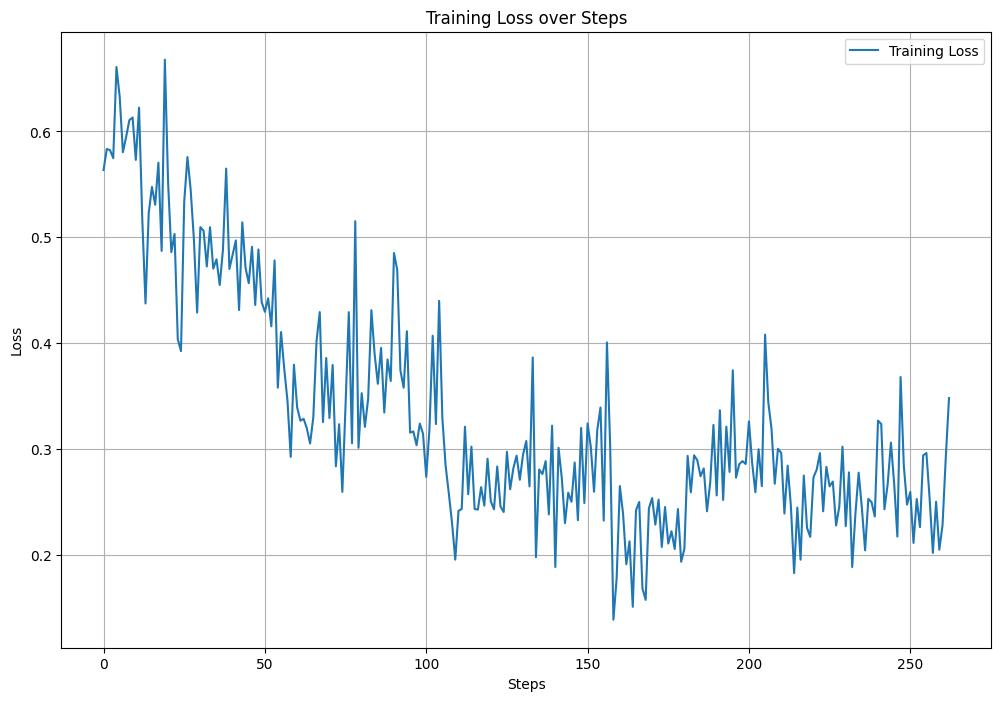

In [ ]:
import matplotlib.pyplot as plt

# Fetch the training loss from trainer's state.
training_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]

# Create a range of steps
steps = list(range(len(training_loss)))

plt.figure(figsize=(12, 8))
plt.plot(steps, training_loss, label='Training Loss')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss over Steps')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import f1_score
import numpy as np
predictions, labels, _ = trainer.predict(eval_dataset)
preds = np.argmax(predictions, axis=1)

In [ ]:
f1 = f1_score(labels, preds, average='weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.6040411042664772


In [ ]:
pred = pd.read_csv('test.csv')
pred['text'] = pred['text'].str.replace('\n', ' ')
pred['text'] = pred['text'].apply(preprocess_text)

In [ ]:
pred_dataset = Dataset.from_pandas(pred)
pred_dataset = pred_dataset.map(tokenize, batched=True, batch_size = len(pred_dataset))

Map:   0%|          | 0/8943 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

pred_dataset = CustomDataset(pred_encoded)
dataloader = DataLoader(pred_dataset, batch_size=1)  # Here, batch_size is 1 as an example.


In [ ]:
model.eval()
preds_list = [] # list to collect all predictions
for batch in tqdm(dataloader):
    with torch.no_grad():
        inputs = {key: val.to(device) for key, val in batch.items() if key != 'token_type_ids'}
        output = model(**inputs)
        _, logits = output
        predictions = torch.nn.functional.softmax(logits, dim=-1)
        preds = torch.argmax(predictions, dim=1)
        preds_list.extend(preds.cpu().numpy()) # append predictions to list

100%|██████████| 8943/8943 [01:57<00:00, 76.22it/s]


In [ ]:
output = pd.read_csv('submission.csv')
output['pred_label']=preds_list
output.to_csv('submission_hf_bert_2.csv', index = False)